# Module Retention Analysis

## Step 1: Load the Dataset

In [9]:

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'student_data.csv'
student_data = pd.read_csv(file_path)

# Display basic information about the dataset to understand its structure
student_data.info()

# Display the first few rows of the dataset for inspection
student_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   hed__Contact__c                    141 non-null    object 
 1   mor_Attendance_Score__c            119 non-null    float64
 2   IP_Grade_Average__c                123 non-null    float64
 3   mor_Total_Activity_Time__c         140 non-null    float64
 4   Participations_Level__c            117 non-null    float64
 5   Page_Views_Level__c                117 non-null    float64
 6   hed__Course_Offering__c            141 non-null    object 
 7   Prerequisite_Course_Connection__c  0 non-null      float64
dtypes: float64(6), object(2)
memory usage: 8.9+ KB


,hed__Contact__c,mor_Attendance_Score__c,IP_Grade_Average__c,mor_Total_Activity_Time__c,Participations_Level__c,Page_Views_Level__c,hed__Course_Offering__c,Prerequisite_Course_Connection__c
0,0034K00000B8uNfQAJ,NaN,0.00,NaN,NaN,NaN,a0R4K000001ynYnUAI,NaN
1,0034K000009yICAQA2,NaN,0.00,0.0,NaN,NaN,a0R4K000001ynYnUAI,NaN
2,0034K00000BAy3UQAT,100.0,98.61,1158852.0,2.0,3.0,a0R4K000001ynYnUAI,NaN
3,0034K00000B8gOLQAZ,NaN,0.00,31315.0,NaN,NaN,a0R4K000001ynYnUAI,NaN
4,0034K00000B8gOlQAJ,NaN,0.00,1150.0,NaN,NaN,a0R4K000001ynYnUAI,NaN


## Step 2: Clean the Data

In [10]:
# Mapping for course modules based on the problem description
course_module_mapping = {
    "a0R4K000001ynYnUAI": "Intro to Software Development",
    "a0R4K000001ynYoUAI": "Angular",
    "a0R4K000001ynYpUAI": "Java",
    "a0R4K000001ynYqUAI": "Python",
    "a0R4K000001ynYrUAI": "Android",
    "a0R4K000001ynYsUAI": "Django",
    "a0R4K000001ynYtUAI": "Professional Development"
}

# Add a column with the module names based on the mapping
student_data['Module'] = student_data['hed__Course_Offering__c'].map(course_module_mapping)

# Drop irrelevant columns (like Prerequisite_Course_Connection__c, which is entirely NaN)
cleaned_data = student_data.drop(columns=['Prerequisite_Course_Connection__c'])

# Define helper functions for cleaning based on rules
def mark_dropout(row):
    key_metrics = [
        row['mor_Attendance_Score__c'],
        row['IP_Grade_Average__c'],
        row['mor_Total_Activity_Time__c'],
        row['Participations_Level__c'],
        row['Page_Views_Level__c']
    ]
    return all(pd.isna(metric) or metric == 0 for metric in key_metrics)

def mark_failed(row, next_module):
    return (row['IP_Grade_Average__c'] < 50) and (next_module not in student_modules.get(row['hed__Contact__c'], []))

# Group data by student to analyze module progression
student_modules = cleaned_data.groupby('hed__Contact__c')['Module'].apply(list).to_dict()

# Create flags for dropouts and failures
cleaned_data['Dropped_Out'] = cleaned_data.apply(mark_dropout, axis=1)

# Identify failures by comparing with subsequent modules
cleaned_data['Failed'] = False
module_order = [
    "Intro to Software Development", "Angular", "Java", "Python", "Android", "Django", "Professional Development"
]

for i in range(len(module_order) - 1):
    current_module = module_order[i]
    next_module = module_order[i + 1]
    cleaned_data.loc[
        (cleaned_data['Module'] == current_module),
        'Failed'
    ] = cleaned_data.apply(lambda row: mark_failed(row, next_module), axis=1)

# Display the cleaned dataset
cleaned_data.head()


,hed__Contact__c,mor_Attendance_Score__c,IP_Grade_Average__c,mor_Total_Activity_Time__c,Participations_Level__c,Page_Views_Level__c,hed__Course_Offering__c,Module,Dropped_Out,Failed
0,0034K00000B8uNfQAJ,NaN,0.00,NaN,NaN,NaN,a0R4K000001ynYnUAI,Intro to Software Development,True,True
1,0034K000009yICAQA2,NaN,0.00,0.0,NaN,NaN,a0R4K000001ynYnUAI,Intro to Software Development,True,True
2,0034K00000BAy3UQAT,100.0,98.61,1158852.0,2.0,3.0,a0R4K000001ynYnUAI,Intro to Software Development,False,False
3,0034K00000B8gOLQAZ,NaN,0.00,31315.0,NaN,NaN,a0R4K000001ynYnUAI,Intro to Software Development,False,True
4,0034K00000B8gOlQAJ,NaN,0.00,1150.0,NaN,NaN,a0R4K000001ynYnUAI,Intro to Software Development,False,True


## Step 3: Retention Rate Analysis

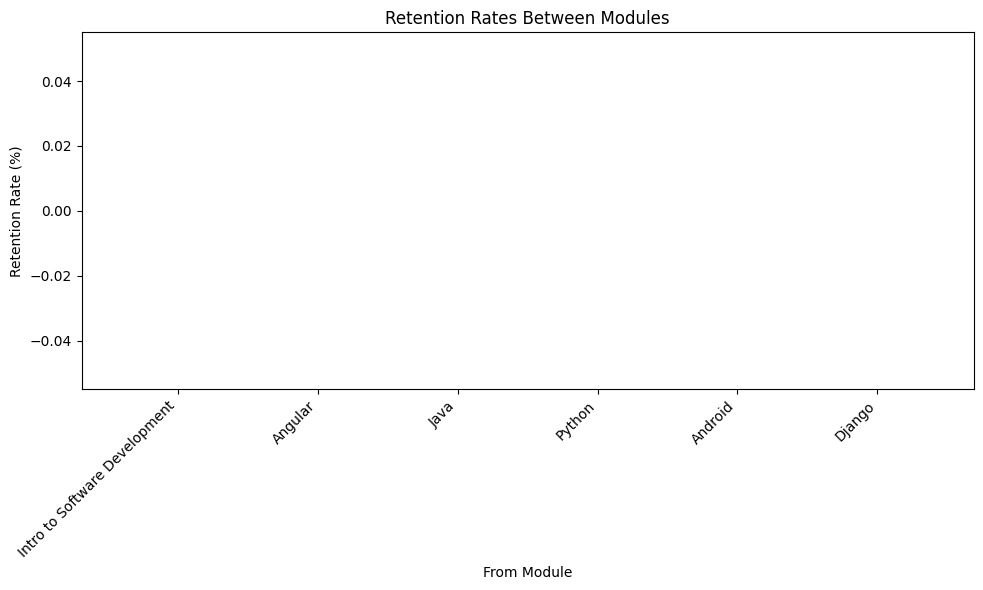

,From,To,Retention_Rate (%)
0,Intro to Software Development,Angular,0.0
1,Angular,Java,0.0
2,Java,Python,0.0
3,Python,Android,0.0
4,Android,Django,0.0
5,Django,Professional Development,0.0


In [11]:

# Calculate retention rates between modules
cleaned_data['Retained'] = ~cleaned_data['Dropped_Out'] & ~cleaned_data['Failed']

# Calculate retention rates between consecutive modules
retention_summary = []
for i in range(len(module_order) - 1):
    current_module = module_order[i]
    next_module = module_order[i + 1]
    current_students = cleaned_data[cleaned_data['Module'] == current_module]['hed__Contact__c'].unique()
    next_students = cleaned_data[cleaned_data['Module'] == next_module]['hed__Contact__c'].unique()
    retained_students = len(set(current_students) & set(next_students))
    retention_rate = (retained_students / len(current_students)) * 100 if len(current_students) > 0 else 0
    retention_summary.append({
        "From": current_module,
        "To": next_module,
        "Retention_Rate (%)": retention_rate
    })

retention_df = pd.DataFrame(retention_summary)

# Visualize the retention rates
plt.figure(figsize=(10, 6))
plt.bar(retention_df['From'], retention_df['Retention_Rate (%)'], align='center')
plt.xticks(rotation=45, ha='right')
plt.title('Retention Rates Between Modules')
plt.xlabel('From Module')
plt.ylabel('Retention Rate (%)')
plt.tight_layout()
plt.show()

retention_df


## Step 4: Correlation Analysis

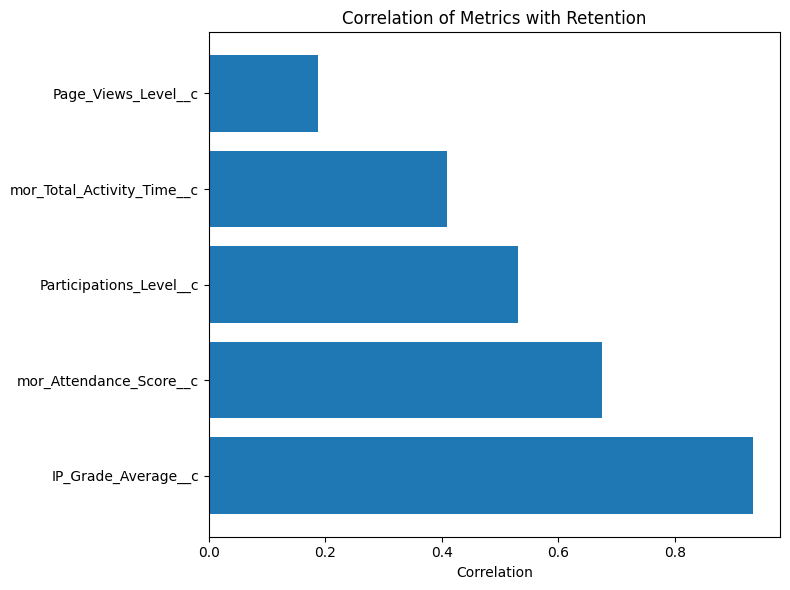

,Metric,Correlation
0,IP_Grade_Average__c,0.934248
1,mor_Attendance_Score__c,0.675943


In [12]:

# Correlation analysis: Retention vs Metrics
cleaned_data['Retained_Numeric'] = cleaned_data['Retained'].astype(int)
metrics_to_correlate = [
    'mor_Attendance_Score__c', 
    'IP_Grade_Average__c', 
    'mor_Total_Activity_Time__c', 
    'Participations_Level__c', 
    'Page_Views_Level__c'
]

correlations = {}
for metric in metrics_to_correlate:
    correlation = cleaned_data[[metric, 'Retained_Numeric']].corr().iloc[0, 1]
    correlations[metric] = correlation

# Sort metrics by absolute correlation value
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
top_metrics = sorted_correlations[:2]
top_metrics_df = pd.DataFrame(top_metrics, columns=['Metric', 'Correlation'])

# Visualize the correlations
plt.figure(figsize=(8, 6))
plt.barh([x[0] for x in sorted_correlations], [x[1] for x in sorted_correlations], align='center')
plt.title('Correlation of Metrics with Retention')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

top_metrics_df
